# Analyze cocktails interactions : Tailored vs. Generic vs. Baseline

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from scipy.stats import mannwhitneyu, ttest_rel, ttest_ind, monte_carlo_test
# from statannotations.Annotator import Annotator

sns.set_style("ticks")
np.random.seed(0)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 15
plt.rcParams['svg.fonttype'] = 'none'

# palette for (1) baseline vs. (2) generic vs. (3) tailored
palette = sns.color_palette(["#bbbbbb", "#0E2982", "#386851",])

print(os.getcwd())

d:\These\50_quotidien\50_papers\2023_coli\code\coli_phage_interactions_2023\dev\cocktails


In [25]:
cml = pd.read_csv("data/CML_COCKTAILS.csv", sep=";")
picard_test_features = pd.read_csv("data/picard+test_collections.csv", sep=";").set_index("bacteria")
bact_features = pd.read_csv("data/test_collection.csv", sep=";").set_index("bacteria")
cocktails_compo = pd.read_csv("data/cocktails_composition.csv", sep=";")
cocktails_step = pd.read_csv("data/cocktails_step.csv", sep=";")[["bacteria", "phage", "chosen_at_step", "rank"]]
phage_features = pd.read_csv("../../data/genomics/phages/guelin_collection.csv", sep=";").set_index("phage")
interaction_matrix = pd.read_csv("../../data/interactions/interaction_matrix.csv", sep=";").set_index("bacteria")
tree = pd.read_csv("data/picard+test_collection_phylogenetic_distances.tsv", sep="\t").set_index("bacteria")

n_infect_phages = (interaction_matrix > 0).astype(int).sum(axis=0).reset_index().rename({"index": "phage", 0: "n_infections"}, axis=1)
phage_features = pd.merge(phage_features, n_infect_phages, left_index=True, right_on="phage").set_index("phage")

cml_long = cml.set_index("bacteria")[["p1", "p2", "p3"]].stack().reset_index().rename({"level_1": "cocktail", 0: "cml_score"}, axis=1)
cml_long = pd.merge(cml_long, cocktails_compo.drop("cocktails_str", axis=1).set_index("bacteria").stack().reset_index().rename({"level_1": "cocktail", 0: "phage"}, axis=1),
                    left_on=["bacteria", "cocktail"], right_on=["bacteria", "cocktail"])
cml_long = pd.merge(cml_long, cocktails_step, on=["bacteria", "phage"])

# Identify which cocktails are tailored vs. generic (The three most recommended ones with generalist phage)
cml["is_tailored"] = True
generic_cocktails = cocktails_compo.loc[cocktails_compo["cocktails_str"].isin(["55989_P2-DIJ07_P2-LF82_P8", "536_P7-LF82_P8-LF82_P9",
                                                                               "55989_P2-LF82_P9-DIJ07_P2", "536_P7-DIJ07_P2-LF82_P8"]), "bacteria"]
cml.loc[cml["bacteria"].isin(generic_cocktails), "is_tailored"] = False

cml.head(5)

,bacteria,p1,p2,p3,b1,b2,b3,p1+p2,p1+p3,p2+p3,b1+b2,b1+b3,b2+b3,p1+p2+p3,b1+b2+b3,is_tailored
0,AN03,6,3,6,6,0,5,5,6,6,5,6,5,5,5,False
1,AN12,4,6,5,4,6,3,5,4,6,6,4,6,5,6,False
2,AN13,0,0,6,2,2,2,0,5,6,1,2,2,6,2,True
3,AN20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,AN22,6,2,0,6,3,2,5,6,2,5,5,2,5,5,False


### 1. Success rate

  Recommendation  Percentage
2       Baseline   81.000000
0        Generic   78.947368
1       Tailored   91.666667


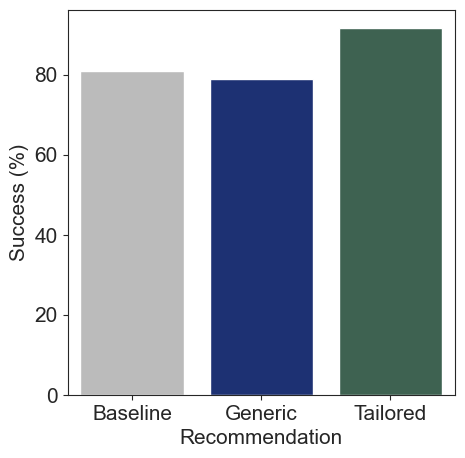

In [3]:
success = cml.copy()
success["Recommendation"] = success["is_tailored"].apply(lambda x: "Tailored" if x else "Generic")

# Count how many successes
success["reco_did_infect"] = success["p1+p2+p3"] > 0 
success["base_did_infect"] = success["b1+b2+b3"] > 0 

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = success.groupby("Recommendation").size()

n_successes = success.groupby("Recommendation")["reco_did_infect"].sum() / n_tailored_vs_generic * 100
n_successes.loc["Baseline"] = success["base_did_infect"].sum() / 100 * 100
n_successes = n_successes.reset_index().rename({0: "Percentage"}, axis=1)
n_successes = n_successes.sort_values("Recommendation")

print(n_successes)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(data=n_successes.reset_index(), x="Recommendation", y="Percentage", palette=palette, ax=ax)
ax.set_ylabel("Success (%)")
# ax.set_title("Percentage of success (MLC > 0) for each type of cocktail")

save_figure = False
if save_figure:
    plt.savefig("tailored_vs_generic_cocktails_breadth.svg")

### 2. MLC

In [4]:
def get_binned_MLC(c):
    """
    Return binned MLC value (Not infecting, Low, Medium or High). Binned intervals are all of size 2 except for "Not infecting".
    """
    if c == 0:
        return "Not infecting"
    elif 1 <= c < 3:
        return "Low"
    elif 3 <= c < 5:
        return "Medium"
    elif 5 <= c < 7:
        return "High"
    else:
        raise ValueError(f"MLC should be between 0 and 6 (included). c value is {c} which is out of range !")

# Compute CML for each cocktail
max_cml_score = 6
tail_vs_generic = []
for i, bact in cml.iterrows():
    tail_vs_generic.append({"bacteria": bact["bacteria"], "cocktail MLC": bact["p1+p2+p3"], "#infecting": (bact["p1"] > 0) + (bact["p2"] > 0) + (bact["p3"] > 0), "cumulative MLC": bact[["p1", "p2", "p3"]].sum() / (max_cml_score*3), "Model": "Recommendation", "Recommendation is tailored": bact["is_tailored"],
    "Binned MLC": get_binned_MLC(bact["p1+p2+p3"])})
    tail_vs_generic.append({"bacteria": bact["bacteria"], "cocktail MLC": bact["b1+b2+b3"], "#infecting": (bact["b1"] > 0) + (bact["b2"] > 0) + (bact["b3"] > 0), "cumulative MLC": bact[["b1", "b2", "b3"]].sum() / (max_cml_score*3), "Model": "Baseline", "Recommendation is tailored": bact["is_tailored"],
    "Binned MLC": get_binned_MLC(bact["b1+b2+b3"])})
tail_vs_generic = pd.DataFrame(tail_vs_generic)

# Add Tailored/Generic attribute
tail_vs_generic["Model_tailored"] = "Baseline"
tail_vs_generic.loc[(tail_vs_generic["Model"] == "Recommendation") & (tail_vs_generic["Recommendation is tailored"]), "Model_tailored"] = "Tailored"
tail_vs_generic.loc[(tail_vs_generic["Model"] == "Recommendation") & (~tail_vs_generic["Recommendation is tailored"]), "Model_tailored"] = "Generic"

do_save = False
if do_save:
    to_save = tail_vs_generic[["bacteria", "Model_tailored", "did_not_infect", "cocktail MLC", "cumulative MLC"]]
    to_save.to_csv("D:\\These\\20_data\\212_interaction_matrices\\cocktails\\results\\CML_results.csv", sep="\t")

tail_vs_generic.head(5)

,bacteria,cocktail MLC,#infecting,cumulative MLC,Model,Recommendation is tailored,Binned MLC,Model_tailored
0,AN03,5,3,0.833333,Recommendation,False,High,Generic
1,AN03,5,2,0.611111,Baseline,False,High,Baseline
2,AN12,5,3,0.833333,Recommendation,False,High,Generic
3,AN12,6,3,0.722222,Baseline,False,High,Baseline
4,AN13,6,1,0.333333,Recommendation,True,High,Tailored


Recommendation
Baseline    100
Generic      76
Tailored     24
dtype: int64


Text(0.5, 1.0, 'Distribution of the binned MLC for each cocktail given cocktail type')

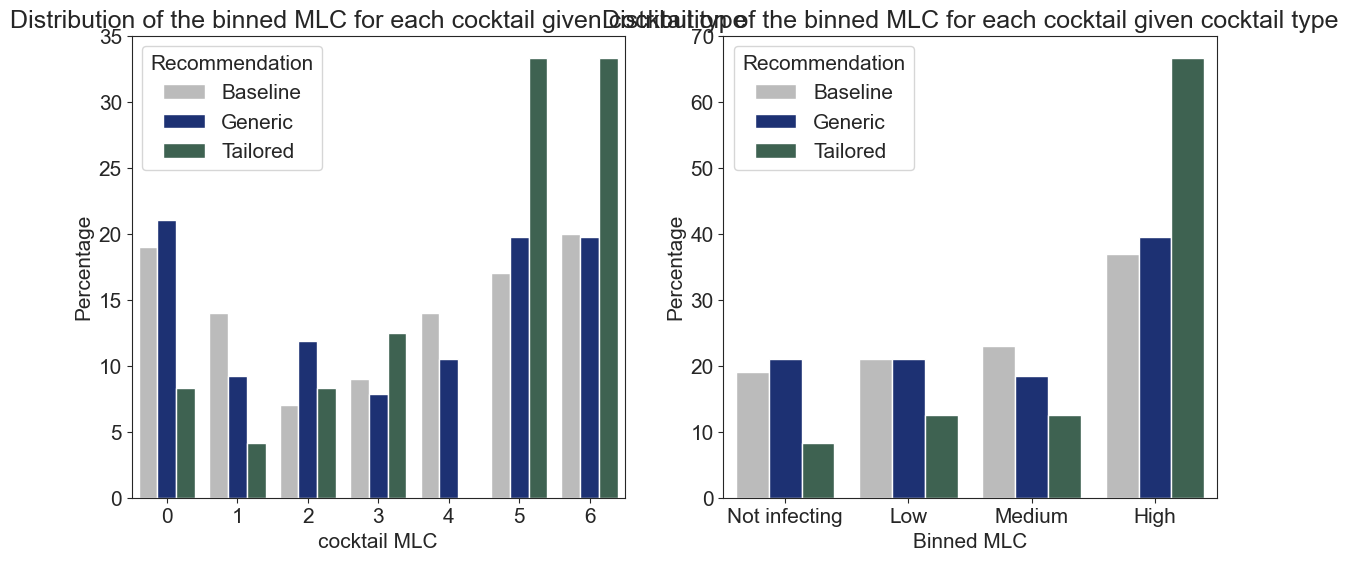

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

tail_vs_generic = tail_vs_generic.rename({"Model_tailored": "Recommendation"}, axis=1)

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = tail_vs_generic.groupby("Recommendation").size()
print(n_tailored_vs_generic)

# Plot raw CML
sns.barplot(data=(tail_vs_generic.value_counts(["Recommendation", "cocktail MLC"]).sort_index() / n_tailored_vs_generic * 100).reset_index().rename({0: "Percentage"}, axis=1), x="cocktail MLC", y="Percentage", hue="Recommendation", palette=palette,  ax=ax[0])
ax[0].set_title("Distribution of the binned MLC for each cocktail given cocktail type")

# Plot binned CML (intervals of 2 each time)
to_plot = tail_vs_generic.value_counts(["Recommendation", "Binned MLC"]).reindex([('Baseline', 'Not infecting'),  ('Generic', 'Not infecting'), ('Tailored', 'Not infecting'), ('Baseline', 'Low'), ('Generic', 'Low'), ('Tailored', 'Low'), ('Baseline', 'Medium'), ('Generic', 'Medium'), ('Tailored', 'Medium'),  ('Baseline', 'High'), ('Generic','High'), ('Tailored', 'High'),])
sns.barplot(data=(to_plot / n_tailored_vs_generic * 100).reset_index().rename({0: "Percentage"}, axis=1), x="Binned MLC", y="Percentage", hue="Recommendation", palette=palette,  ax=ax[1])
ax[1].set_title("Distribution of the binned MLC for each cocktail given cocktail type")

Recommendation
Baseline    100
Generic      76
Tailored     24
dtype: int64


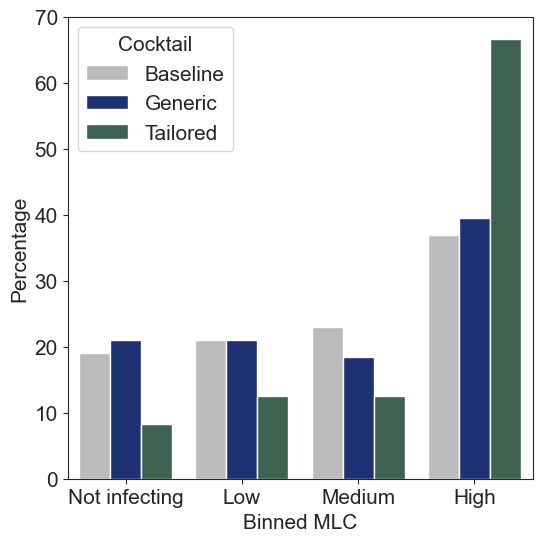

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

tail_vs_generic = tail_vs_generic.rename({"Model_tailored": "Recommendation"}, axis=1)

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = tail_vs_generic.groupby("Recommendation").size()
print(n_tailored_vs_generic)

# Plot binned CML (intervals of 2 each time)
to_plot = (tail_vs_generic.value_counts(["Recommendation", "Binned MLC"]).reindex([('Baseline', 'Not infecting'),  ('Generic', 'Not infecting'), ('Tailored', 'Not infecting'), ('Baseline', 'Low'), ('Generic', 'Low'), ('Tailored', 'Low'), ('Baseline', 'Medium'), ('Generic', 'Medium'), ('Tailored', 'Medium'),  ('Baseline', 'High'), ('Generic','High'), ('Tailored', 'High'),]) / n_tailored_vs_generic * 100).reset_index().rename({0: "Percentage"}, axis=1)
to_plot = to_plot.rename({"Recommendation": "Cocktail"}, axis=1)
sns.barplot(data=to_plot, x="Binned MLC", y="Percentage", hue="Cocktail", palette=palette,  ax=ax)
# ax.set_title("Distribution of the binned MLC for each cocktail given cocktail type")

mlc_res = to_plot.copy()

save_figure = False
if save_figure:
    plt.savefig("tailored_vs_generic_cocktails_binned_MLC.svg")

Recommendation
Baseline    100
Generic      76
Tailored     24
dtype: int64


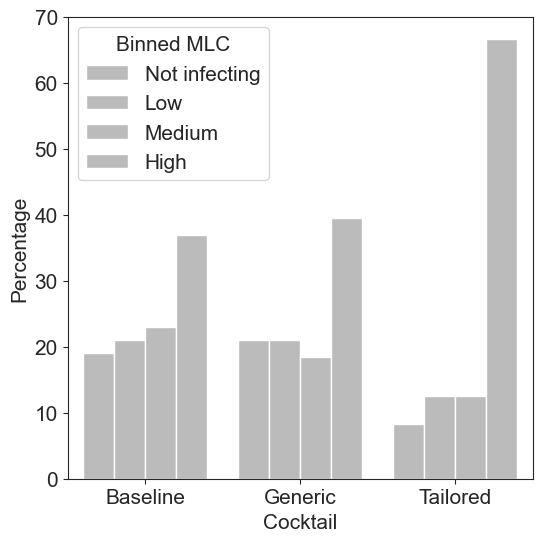

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

tail_vs_generic = tail_vs_generic.rename({"Model_tailored": "Recommendation"}, axis=1)

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = tail_vs_generic.groupby("Recommendation").size()
print(n_tailored_vs_generic)

# Plot binned CML (intervals of 2 each time)
to_plot = (tail_vs_generic.value_counts(["Recommendation", "Binned MLC"]).reindex([('Baseline', 'Not infecting'), ('Baseline', 'Low'), ('Baseline', 'Medium'), ('Baseline', 'High'), ('Generic', 'Not infecting'), ('Generic', 'Low'), ('Generic', 'Medium'), ('Generic','High'), ('Tailored', 'Not infecting'),  ('Tailored', 'Low'),  ('Tailored', 'Medium'),  ('Tailored', 'High'),]) / n_tailored_vs_generic * 100).reset_index().rename({0: "Percentage"}, axis=1)

col_pal = [palette[0]]

to_plot = to_plot.rename({"Recommendation": "Cocktail"}, axis=1)
sns.barplot(data=to_plot, hue="Binned MLC", y="Percentage", x="Cocktail", palette=col_pal,  ax=ax)
# ax.set_title("Distribution of the binned MLC for each cocktail given cocktail type")

save_figure = True
if save_figure:
    plt.savefig("tailored_vs_generic_cocktails_binned_MLC_2.svg")

In [10]:
# Statistical test : Compare recommendations with baseline
print("(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria) (Paired t-test)")
tailored = cml.loc[cml["is_tailored"]]
print(ttest_rel(tailored["p1+p2+p3"], tailored["b1+b2+b3"]))
print("\n")

print("(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria) (Mann-Whitney)")
tailored = cml.loc[cml["is_tailored"]]
print(mannwhitneyu(tailored["p1+p2+p3"], tailored["b1+b2+b3"], alternative="two-sided"))

print("----------------------------------------------------------------------\n")

print("(H_0) : \mu(tailored) == \mu(baseline on all bacteria) (Mann-Whitney)")
print(mannwhitneyu(tailored["p1+p2+p3"], cml["b1+b2+b3"]))
print("\n")

print("----------------------------------------------------------------------\n")

generic = cml.loc[~cml["is_tailored"]]

print("(H_0) : \mu(tailored) == \mu(generic) (Mann-Whitney)")
print(mannwhitneyu(tailored["p1+p2+p3"], generic["p1+p2+p3"]))

print("----------------------------------------------------------------------\n")

print("(H_0) : \mu(generic) == \mu(baseline on all bacteria) (Mann-Whitney)")
print(mannwhitneyu(generic["p1+p2+p3"], cml["b1+b2+b3"]))
print("\n")

(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria) (Paired t-test)
Ttest_relResult(statistic=2.3183072457486023, pvalue=0.0296760217738437)


(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria) (Mann-Whitney)
MannwhitneyuResult(statistic=399.5, pvalue=0.018971875313119994)
----------------------------------------------------------------------

(H_0) : \mu(tailored) == \mu(baseline on all bacteria) (Mann-Whitney)
MannwhitneyuResult(statistic=1543.5, pvalue=0.027702085277870193)


----------------------------------------------------------------------

(H_0) : \mu(tailored) == \mu(generic) (Mann-Whitney)
MannwhitneyuResult(statistic=1171.5, pvalue=0.03351336230694329)
----------------------------------------------------------------------

(H_0) : \mu(generic) == \mu(baseline on all bacteria) (Mann-Whitney)
MannwhitneyuResult(statistic=3800.0, pvalue=1.0)




### 3. #infecting phages in the cocktail

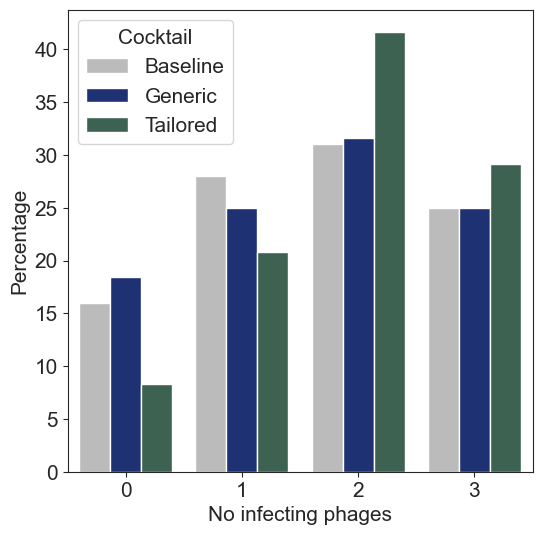

In [12]:
n_infecting = cml.copy()
n_infecting["Recommendation"] = success["is_tailored"].apply(lambda x: "Tailored" if x else "Generic")

# Count number of infecting phages
n_infecting["#infecting_reco"] = (n_infecting["p1"] > 0).astype(int) + (n_infecting["p2"] > 0).astype(int) + (n_infecting["p3"] > 0).astype(int)
n_infecting["#infecting_base"] = (n_infecting["b1"] > 0).astype(int) + (n_infecting["b2"] > 0).astype(int) + (n_infecting["b3"] > 0).astype(int)

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = tail_vs_generic.groupby("Recommendation").size()

to_plot = (n_infecting.value_counts(["Recommendation", "#infecting_reco"]) / n_tailored_vs_generic) * 100

n_infect_baseline = n_infecting.value_counts("#infecting_base")
for k in n_infect_baseline.index:
    to_plot.loc[("Baseline", k)] = n_infect_baseline[k] # / 100 * 100

to_plot = to_plot.reindex([('Baseline', 0), ('Generic', 0), ('Tailored', 0), ('Baseline', 1), ('Generic', 1), ('Tailored', 1), ('Baseline', 2), ('Generic', 2), ('Tailored', 2), ('Baseline', 3), ('Generic', 3), ('Tailored', 3),])

# Compute how many generic and how many tailored cocktails there are
n_tailored_vs_generic = n_infecting.groupby("Recommendation").size()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(data=to_plot.reset_index().rename({0: "Percentage", "#infecting_reco": "No infecting phages"}, axis=1).rename({"Recommendation": "Cocktail"}, axis=1), x="No infecting phages", y="Percentage", hue="Cocktail", palette=palette, ax=ax)
# ax.legend(loc="upper left")

save_figure = False
if save_figure:
    plt.savefig("tailored_vs_generic_cocktails_n_infecting.svg")

In [13]:
# Statistical test : Compare recommendations with baseline
print("(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria)")
tailored = n_infecting.loc[n_infecting["is_tailored"]]
print(mannwhitneyu(tailored["#infecting_reco"], tailored["#infecting_base"], alternative="two-sided"))
print("\n")

print("(H_0) : \mu(generic) == \mu(baseline on generic bacteria)")
generic = n_infecting.loc[~n_infecting["is_tailored"]]
print(mannwhitneyu(generic["#infecting_reco"], generic["#infecting_base"], alternative="two-sided"))
print("\n")

print("(H_0) : \mu(tailored) == \mu(generic)")
print(mannwhitneyu(tailored["#infecting_reco"], generic["#infecting_reco"], alternative="two-sided"))
print("\n")

(H_0) : \mu(tailored) == \mu(baseline on tailored bacteria)
MannwhitneyuResult(statistic=276.5, pvalue=0.8117918741207951)


(H_0) : \mu(generic) == \mu(baseline on generic bacteria)
MannwhitneyuResult(statistic=3017.0, pvalue=0.6227857438985192)


(H_0) : \mu(tailored) == \mu(generic)
MannwhitneyuResult(statistic=1047.0, pvalue=0.2591102292945463)




### BONUS : Clarify the definition of generic vs. tailored cocktails

In [15]:
# Number of ST to which each cocktail is predicted
tailored_bact = cml.loc[cml["is_tailored"], "bacteria"].values

cocktails_compo["is_tailored"] = True
generic_cocktails = cocktails_compo.loc[cocktails_compo["cocktails_str"].isin(["55989_P2-DIJ07_P2-LF82_P8", "536_P7-LF82_P8-LF82_P9",
                                                                               "55989_P2-LF82_P9-DIJ07_P2"]), "bacteria"]
cocktails_compo.loc[cocktails_compo["bacteria"].isin(generic_cocktails), "is_tailored"] = False

st_per_cocktail = []
bact_count = {}
for c, grp in cocktails_compo.groupby("cocktails_str"):
    bact = grp["bacteria"].values
    st_list = np.unique(bact_features.loc[bact, ["ST_Warwick", "O-type", "H-type"]].fillna("").apply(lambda x: "/".join(x), axis=1).values)
    st_per_cocktail.append({"cocktail": c, "n_st_o_h": st_list.shape[0]})
st_per_cocktail = pd.DataFrame(st_per_cocktail).sort_values("n_st_o_h", ascending=False)

import string
to_plot = cocktails_compo.value_counts("cocktails_str").reset_index()
to_plot["Cocktail"] = [string.ascii_uppercase[i] for i in range(to_plot.shape[0])]
st_per_cocktail["Cocktail"] = [string.ascii_uppercase[i] for i in range(st_per_cocktail.shape[0])]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(data=st_per_cocktail.sort_values("n_st_o_h", ascending=False), x="Cocktail", y="n_st_o_h", ax=ax, color=palette[1])
# sns.barplot(data=to_plot, x="Cocktail", y="count", ax=ax, color="#223868")
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_ylabel("Count")
ax.set_xlabel("Cocktail")
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize": 11});
# ax.set_title("Number of distinct ST/O/H on which each cocktail is predicted")

plt.savefig("tailored_vs_generic_haplotype_distribution.svg")

TypeError: sequence item 0: expected str instance, int found

### BONUS : Compare the performance of the baseline on bacteria which are recommended a generic vs. tailored cocktail

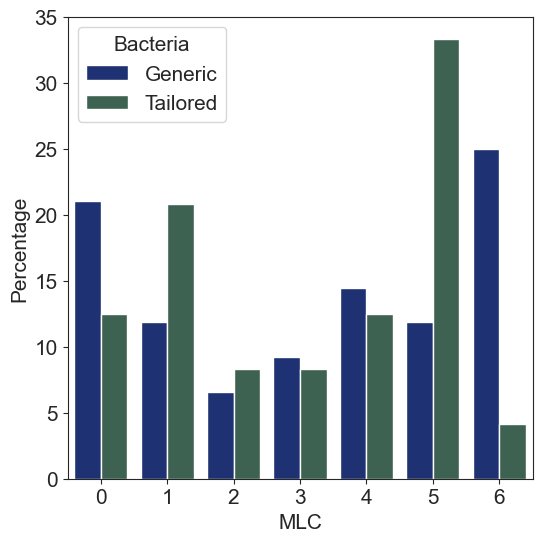

In [16]:
to_plot = cml.copy().replace({True: "Tailored", False: "Generic"})
n_tailored_vs_generic = to_plot.value_counts("is_tailored")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(data=(to_plot.value_counts(["is_tailored", "b1+b2+b3"]) / n_tailored_vs_generic * 100).sort_index().reset_index().rename({"b1+b2+b3": "MLC", "count": "Percentage", "is_tailored": "Bacteria"}, axis=1), x="MLC", y="Percentage", hue="Bacteria", palette=palette[1:], ax=ax)
# ax.set_title("MLC of the baseline given the group of bacteria\n(Was recommended a tailored cocktail (green) vs. Generic (blue))")

do_save = False
if do_save:
    plt.savefig("baseline_MLC_on_tailored_vs_generic_bacteria.svg")

In [17]:
# Compare b1+b2+b3 on bacteria which are predicted the generic vs. predicted the tailored cocktails
print("(H_0) : \mu(bacteria tailored cocktail) == \mu(bacteria generic cocktail)")
tailored, generic = cml.loc[cml["is_tailored"]], cml.loc[~cml["is_tailored"]]
mannwhitneyu(tailored["b1+b2+b3"], generic["b1+b2+b3"])

(H_0) : \mu(bacteria tailored cocktail) == \mu(bacteria generic cocktail)


MannwhitneyuResult(statistic=862.5, pvalue=0.688595426892725)

### Bonus : Another way of viewing the same idea
- We draw MLC(reco) vs. MLC(baseline) to investigate if there is a relationship between "the recommendation is strong on B" and "the baseline is strong on B". 
- By separating between tailored and generic cocktails, we observe that
    - We get a better fit for ```MLC(reco | generic) ~ MLC(baseline | generic)``` indicating that there is stronger correlation which is expected since generic recommended cocktails "look like" the baseline (at least more than the tailored cocktails)
    - We get a larger intercept for ```MLC(reco | tailored) ~ MLC(baseline | tailored)``` indicating that the performance of the tailored recommendations remain pretty good even when the ones of the baseline crumble down. 

MLC(reco | tailored) ~ MLC(baseline | tailored)
                            OLS Regression Results                            
Dep. Variable:               p1_p2_p3   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.4739
Date:                Sun, 26 Nov 2023   Prob (F-statistic):              0.498
Time:                        14:35:02   Log-Likelihood:                -49.627
No. Observations:                  24   AIC:                             103.3
Df Residuals:                      22   BIC:                             105.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

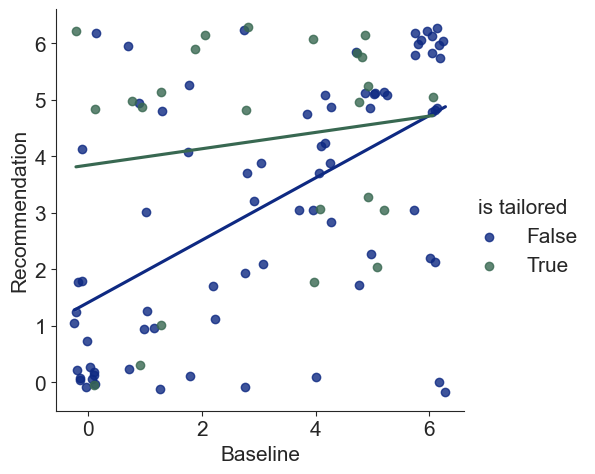

In [18]:
to_plot = cml[["b1+b2+b3", "p1+p2+p3", "is_tailored"]].copy()

# add jitter
to_plot["b1+b2+b3"] = to_plot["b1+b2+b3"] + np.random.uniform(-0.3, 0.3, size=to_plot["b1+b2+b3"].shape)
to_plot["p1+p2+p3"] = to_plot["p1+p2+p3"] + np.random.uniform(-0.3, 0.3, size=to_plot["p1+p2+p3"].shape)

# linear regression
from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf
print("MLC(reco | tailored) ~ MLC(baseline | tailored)")
# print(linregress(to_plot.loc[to_plot["is_tailored"], "b1+b2+b3"], to_plot.loc[to_plot["is_tailored"], "p1+p2+p3"]))
lm_tail = smf.ols("p1_p2_p3 ~ b1_b2_b3", to_plot.loc[to_plot["is_tailored"]].rename({"b1+b2+b3": "b1_b2_b3", "p1+p2+p3": "p1_p2_p3"}, axis=1))
lmf_tail = lm_tail.fit()
print(lmf_tail.summary())
print("\n")

print("MLC(reco | generic) ~ MLC(baseline | generic)")
# print(linregress(to_plot.loc[~to_plot["is_tailored"], "b1+b2+b3"], to_plot.loc[~to_plot["is_tailored"], "p1+p2+p3"]))
lm_gen = smf.ols("p1_p2_p3 ~ b1_b2_b3", to_plot.loc[~to_plot["is_tailored"]].rename({"b1+b2+b3": "b1_b2_b3", "p1+p2+p3": "p1_p2_p3"}, axis=1))
lmf_gen = lm_gen.fit()
print(lmf_gen.summary())
print("\n")

to_plot = to_plot.rename({"p1+p2+p3": "Recommendation", "b1+b2+b3": "Baseline", "is_tailored": "is tailored"}, axis=1)

f = sns.lmplot(data=to_plot, x="Baseline", y="Recommendation", hue="is tailored", palette=palette[1:], ci=0)
f = f.set_titles("MLC(Recommendation) ~ MLC(Baseline) given the type of recommendation")

do_save = False
if do_save:
    plt.savefig("tailored_vs_generic_regress_against_baseline.svg")

### BONUS : Analyze at which steps of the pipeline generic vs. tailored cocktails are recommended

MannwhitneyuResult(statistic=3856.5, pvalue=3.5135805122715305e-12)


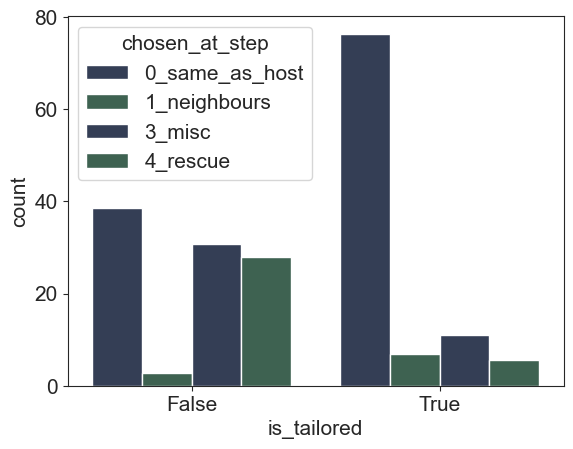

In [69]:
m = pd.merge(cocktails_step, cml, on="bacteria")
counts = m.value_counts("is_tailored")
d = (m.value_counts(["is_tailored", "chosen_at_step"]) / counts * 100).reset_index().sort_values("chosen_at_step")
to_test = m.replace({"0_same_as_host": 1, "1_neighbours": 2, "3_misc": 3, "4_rescue": 4}).groupby("bacteria")["chosen_at_step"].mean().reset_index().merge(m[["bacteria", "is_tailored"]], on="bacteria")

print(mannwhitneyu(to_test.loc[to_test["is_tailored"], "chosen_at_step"], to_test.loc[~to_test["is_tailored"], "chosen_at_step"]))

sns.barplot(data=d, x="is_tailored", y="count", hue="chosen_at_step", palette=palette[1:])
do_save = False
if do_save:
    plt.savefig("tailored_vs_generic_chosen_at_step.svg")

## Cocktail performance as a function of phylogenetic distance to the nearest neighbour in the train set

Here we want to measure how well we generalized given the phylogenetic distance to the nearest neighbour in the original collection (i.e. "how far" we can generalize).

### Success rate as a function of phylogenetic distance to nearest neighbour

In [26]:
def get_nearest_neighbour_in_train_set(bact):
    if bact in tree.columns:
        nearest_neighbours = tree[bact].sort_values(ascending=True)[1:]  # remove d(bact, bact) == 0
        orig_bact = picard_test_features.loc[picard_test_features["Collection"].isin(["ORIGINAL", "HOST"])].index
        orig_bact = orig_bact.drop("LF110")
        nearest_neighbours = nearest_neighbours.loc[orig_bact].sort_values(ascending=True)
        nearest_neigh, dist = nearest_neighbours.index[0], nearest_neighbours[0]
    else:
        return np.nan, np.nan
    return nearest_neigh, dist

near_neighb = []
for b in picard_test_features.loc[picard_test_features["Collection"] == "COCKTAIL"].index:
    nn, d = get_nearest_neighbour_in_train_set(b)
    near_neighb.append({"bacteria": b, "neared_neighbour": nn, "core_phylo_distance": d})
nearest_neighbours = pd.DataFrame(near_neighb).dropna()

nearest_neighbours

,bacteria,neared_neighbour,core_phylo_distance
0,AN03,BDX09,0.000024
1,AN12,AN17,0.000051
2,AN13,DIJ07,0.000036
3,AN20,ECOR-25,0.000294
4,AN22,IAI01,0.001412
...,...,...,...
94,RY25,T205,0.000165
95,RY28,AN17,0.007025
96,RY36,ECOR-60,0.000709
97,BCH838,BDX09,0.000020


Optimization terminated successfully.
         Current function value: 0.487273
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                   91
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            0
Date:                Sun, 26 Nov 2023   Pseudo R-squ.:                 0.02024
Time:                        14:40:08   Log-Likelihood:                -44.342
converged:                       True   LL-Null:                       -45.258
Covariance Type:            nonrobust   LLR p-value:                       nan
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
log_phylo_distance    -0.3999      0.075     -5.298      0.000      -0.548      -0.252


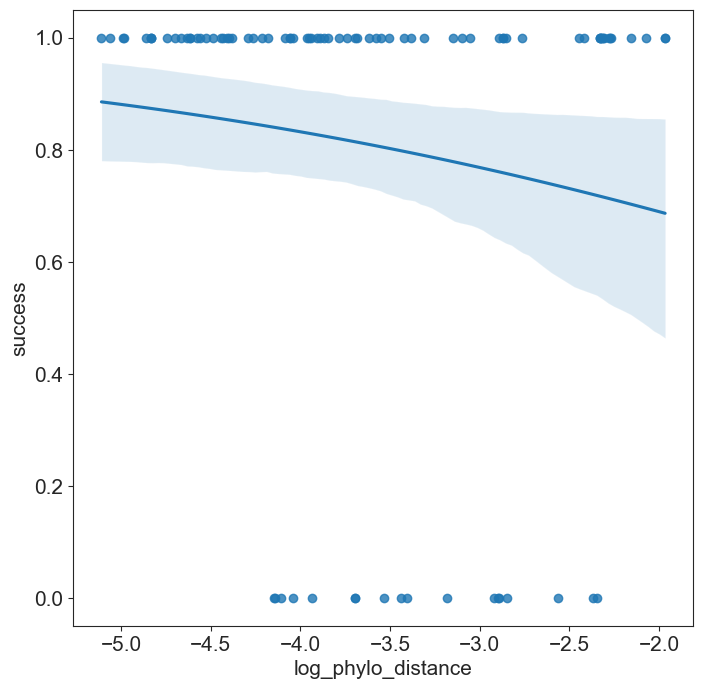

In [27]:
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit 

m = pd.merge(tail_vs_generic, nearest_neighbours[["bacteria", "core_phylo_distance"]], on="bacteria")
m["success"] = (m["cocktail MLC"] > 0).astype(int)
m = m.loc[m["Recommendation"].isin(["Tailored", "Generic"])]
m = m.loc[m["core_phylo_distance"] != 0.0]
m["log_phylo_distance"] = m["core_phylo_distance"].apply(lambda x: np.log10(x))
m = m.dropna()

filter_out_extremes = True
if filter_out_extremes:
    perc = 2
    perc_min, perc_max = np.percentile(m["core_phylo_distance"].values, perc), np.percentile(m["core_phylo_distance"].values, 100-perc)
    m_filt = m.loc[(m["core_phylo_distance"] > perc_min) & (m["core_phylo_distance"] < perc_max)]

mod = Logit(m_filt["success"], m_filt["log_phylo_distance"])
mod_fit = mod.fit()
print(mod_fit.summary())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.regplot(data=m_filt, x="log_phylo_distance", y="success", logistic=True, ax=ax)

do_save = False
if do_save:
    plt.savefig("success_rate_core_vs_log_phylo_distance_to_nearest_neighb.svg")

### MLC score as a function of phylogenetic distance to nearest neighbour

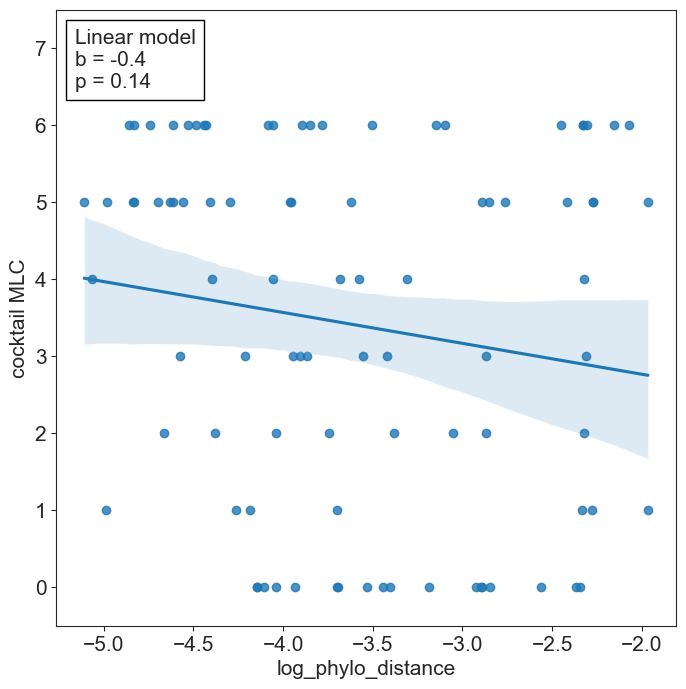

In [136]:
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText

m = pd.merge(tail_vs_generic, nearest_neighbours[["bacteria", "core_phylo_distance"]], on="bacteria")
m = m.loc[m["Recommendation"].isin(["Tailored", "Generic"])]
m = m.loc[m["core_phylo_distance"] != 0.0]
m["log_phylo_distance"] = m["core_phylo_distance"].apply(lambda x: np.log10(x))
m = m.dropna()

filter_out_extremes = True
if filter_out_extremes:
    perc = 2
    perc_min, perc_max = np.percentile(m["core_phylo_distance"].values, perc), np.percentile(m["core_phylo_distance"].values, 100-perc)
    m_filt = m.loc[(m["core_phylo_distance"] > perc_min) & (m["core_phylo_distance"] < perc_max)]

beta, intercept, r, p, std = linregress(m_filt["log_phylo_distance"].values, m_filt["cocktail MLC"].values )

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.regplot(data=m_filt, x="log_phylo_distance", y="cocktail MLC", ax=ax)
text_str = "\n".join(["Linear model", f"b = {round(beta, 2)}", f"p = {round(p, 2)}"])
anchored_text = AnchoredText(text_str, loc=2)
ax.add_artist(anchored_text)
ax.set_ylim(-0.5, 7.5)

do_save = False
if do_save:
    plt.savefig("MLC_perf_core_vs_log_phylo_distance_to_nearest_neighb.svg")